In [1]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

# working with arrays
import numpy as np

# plotting functionality
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from scipy import stats

# typehints
from typing import Tuple

"""
Own packages
"""
from codelib.visualization.base import risk_waterfall_chart

from codelib.statistics.cornish_fisher import calculate_cornish_fisher_percentile

from codelib.visualization.layout import DefaultStyle
DefaultStyle();

# Introduction to risk measures  

## Risk measures

We can think of a risk measure as a dissatisfaction index that quantifies financial risk. More formally, a risk measure is a function, $\varrho(\mathbf{X})$, that maps a set of random variables, $\mathbf{X}$,  (e.g. future value of assets or portfolio returns) to the real numbers, $\varrho: \mathcal{L} \to \mathbb{R} \cup \{+ \infty\}$. The function $\varrho(\mathbf{X})$ needs to satisfy certain properties (for further reference, see [Artzner et al (1999), "Coherent Measures of Risks"](https://onlinelibrary.wiley.com/doi/abs/10.1111/1467-9965.00068)). 

__Normalization__

The risk associated with holding no assets is zero

$$
\varrho(0) = 0
$$

__Monotonicity__

If $\mathbf{X}_1, \mathbf{X}_2 \in \mathcal{L}$ and $\mathbf{X}_1 \leq \mathbf{X}_2$ almost surely (with probability 1), then 

$$
\varrho(\mathbf{X}_1) \geq \varrho(\mathbf{X}_2)
$$

__Translation invariance__

If $\mathbf{A}$ is a deterministic portfolio with guaranteed return $a$ and $Z \in \mathcal{L}$ then

$$
\varrho (Z+A)=\varrho (Z)-a
$$

The portfolio $\mathbf{A}$ is just adding cash $a$ to your portfolio $Z$. In particular, if $a=\varrho(Z)$ then $\varrho(Z+A)=0$. In financial risk management, translation invariance implies that the addition of a sure amount of capital reduces the risk by the same amount.

### Coherent risk measures

A [coherent risk measure](https://en.wikipedia.org/wiki/Coherent_risk_measure) additionally satisfies the properties of *monotonicity*, *sub-additivity*, *homogeneity*, and *translational invariance*. One example of a popular coherent risk measure is  [Conditional-Value-at-Risk (CVaR) / Expected shortfall](https://en.wikipedia.org/wiki/Expected_shortfall), while the risk measure [Value-at-Risk](https://en.wikipedia.org/wiki/Value_at_risk) is not coherent (in the case of a non-elliptical distribution). 

__Sub-additivity__

Sub-additivity implies that diversification is beneficial meaning that the risk of two portfolios together is less than adding their individual risk

$$
\mathrm{If}\; Z_1,Z_2 \in \mathcal{L} ,\; \mathrm{then}\; \varrho(Z_1 + Z_2) \leq \varrho(Z_1) + \varrho(Z_2)
$$

__Positive Homogeneity__

In financial risk management, positive homogeneity implies the risk of a position is proportional to its size. 

A risk measure is said to be [homogeneous](https://en.wikipedia.org/wiki/Homogeneous_function) of degree one if 

$$
\mathrm{If}\; \alpha \ge 0 \; \mathrm{and} \; Z \in \mathcal{L} ,\; \mathrm{then} \; \varrho(\alpha Z) = \alpha \varrho(Z)
$$


### Convex risk measures

The notion of coherence has been subsequently relaxed. Indeed, the notions of sub-additivity and positive homogeneity can be replaced by the notion of convexity:

$$
Z_1,Z_2 \in \mathcal{L}\text{ and }\lambda \in [0,1] \text{ then }\varrho(\lambda Z_1 + (1-\lambda) Z_2) \leq \lambda \varrho(Z_1) + (1-\lambda) \varrho(Z_2)
$$

### Example: Is portfolio standard devation a (coherent) risk measure?

Standard deviation is one of the most used measure of risk in finance, but it is not a coherent risk measure. In fact, it is not even a risk measure based on the above definition!

Let $\mathbf{w}$ denote a vector of portfolio weights and $\boldsymbol{\Sigma}$ denote the covariance matrix of the return vector, $\mathbf{R}$, of the $N$ individual assets. The portfolio standard deviation, $\sigma_P$, is given by

$$
\varrho_{\sigma_P}(\mathbf{w}^\top \mathbf{R}) = \sqrt{\text{Var}\left[\mathbf{w}^\top \mathbf{R} \right] } = \sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}
$$

__Normalization__

A portfolio with zero allocation to all assets has zero risk

$$
\varrho_{\sigma_P}(\mathbf{0}^\top \mathbf{R}) = \sqrt{\mathbf{0}^\top \boldsymbol{\Sigma} \mathbf{0}} = 0
$$

__Monotonicity__

Standard deviation does not satisfy the monotonicity requirement. 

We can easily show this by a counter example. Let $Z_1 = k \times U$ be a portfolio where $U$ is a discrete uniform random variable on the values $-1$ and $1$, $U \sim \mathcal{U}(-1, 1)$ and $k>0$ (somekind of digital option). Thus, the return on the portfolio is either $+k$ og $-k$. Next, let another portfolio be defined by $Z_2 = 2Z_1 + 2k$ (2 digitial options and a cash position). 

Clearly, $Z_2$ dominates $Z_1$ since

$$
\begin{align}
Z_1 = k \; \mathrm{and} \; Z_2 = 4k & \;\mathrm{if} \; U = 1 \\
Z_1 = -k \; \mathrm{and} \; Z_2 = 0 & \; \mathrm{if} \; U = -1
\end{align}
$$

However, $\text{Var}\left[Z_2 \right] > \text{Var}\left[Z_1 \right]$

$$
\begin{align}
\text{Var}\left[Z_1 \right] &= k^2 \frac{3}{12} \\
\text{Var}\left[Z_2 \right] &= 4 \text{Var}\left[Z_1 \right] + 0 = k^2
\end{align}
$$

where we have used the rule $\text{Var}\left[a X + b \right] = a^2\text{Var}\left[X \right] + 0$ and the variance formula for a [uniform random variable](https://en.wikipedia.org/wiki/Discrete_uniform_distribution). 

__Translation invariance__

If $A$ is a deterministic portfolio with guaranteed return $a$, then

$$
\varrho_{\sigma_P}(\mathbf{w}^\top \mathbf{R} + A) = \sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}} + 0 = \varrho_{\sigma_P}(\mathbf{w}^\top \mathbf{R})
$$

Portfolio standard deviation does not satisfy the requirement of translation invariance!

__Positive Homogeneity__

Standard deviation clearly satisfies positive homogeneity

$$
\varrho_{\sigma_P}(\alpha\mathbf{w}^\top \mathbf{R}) = \sqrt{\text{Var}\left[\alpha\mathbf{w}^\top \mathbf{R} \right] } = \sqrt{\alpha^2\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}} = \alpha\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}} = \alpha \cdot \varrho_{\sigma_P}(\mathbf{w}^\top \mathbf{R})
$$

__Sub-additivity__

Consider the two portfolios $Z_1$ and $Z_2$. We know that 

$$
\text{Var}\left[Z_1 + Z_2 \right] = \text{Var}\left[Z_1 \right] + \text{Var}\left[Z_2 \right] + 2\rho_{Z_1, Z_2}\sigma_{Z_1} \sigma_{Z_2}
$$

where the correlation coefficient can take values $\rho_{Z_1, Z_2} \in [-1, 1]$. The last term in the above equation takes its largest value when $\rho_{Z_1, Z_2}=1$ (perfect positive correlation). Thus, 

$$
\text{Var}\left[Z_1 + Z_2 \right] = \text{Var}\left[Z_1 \right] + \text{Var}\left[Z_2 \right] + 2\rho_{Z_1, Z_2}\sigma_{Z_1} \sigma_{Z_2} \leq  \text{Var}\left[Z_1 \right] + \text{Var}\left[Z_2 \right] + 2\sigma_{Z_1} \sigma_{Z_2}
$$

Rewriting in terms of standard deviation, we obtain

$$
\sigma_{Z_1 + Z_2}^2  \leq  \sigma_{Z_1 }^2 + \sigma_{Z_2}^2 + 2\sigma_{Z_1} \sigma_{Z_2} = (\sigma_{Z_1 } + \sigma_{Z_2 })^2
$$

Taking the square root yields

$$
\begin{align}
\sqrt{\sigma_{Z_1 + Z_2}^2}  &\leq  \sqrt{(\sigma_{Z_1 } + \sigma_{Z_2 })^2} \\
\sigma_{Z_1 + Z_2}  &\leq  \sigma_{Z_1 } + \sigma_{Z_2 }
\end{align}
$$

Thus, the standard deviation is sub-additive and promotes diversification. 

# More on risk measures and the objectives of the investor

We have talked about random variables and distributions, so we are ready to talk about how we can calculate these risk measures for a e.g. a portfolio of assets. A risk measure helps us to quantify the dissatisfaction with a given portfolio or investment strategy and is simply a function that maps the random portfolio to the real numbers. The function $\varrho$, as previously discussed, has to satisfy certain properties. 

* Normalization 
* Monotonicity
* Translation invariance

and we will also like it to satisfy

* Sub-additivity
* Homogeneity


## Goal of the investor 

We will generally assume that an investor holds a portfolio of assets with portfolio weights $\mathbf{w}$ ($n \times 1$ vector) such that the value at time $t$ is given by

$$
\mathbf{V}_t = \mathbf{w}^\top \mathbf{P}_t
$$

The investor may care about (we will use $\mathbf{V}_{t + \tau}$ to denote one of these objectives):

__Total value (absolute wealth)__ at the end of the investment horizon 

$$
\mathbf{V}_{t + \tau} = \mathbf{w}^\top \mathbf{P}_{t + \tau}
$$

__Value relative to some benchmark__ at the end of the investment horizon 

$$
\mathbf{V}_{t + \tau} = \mathbf{w}^\top \mathbf{P}_{t + \tau} - \nu(\mathbf{w}, \mathbf{w}_b)\mathbf{w}_b^\top \mathbf{P}_{t + \tau} 
$$

where 

$$
\nu(\mathbf{w}, \mathbf{w}_b) = \frac{\mathbf{w}^\top \mathbf{P}_{t}}{\mathbf{w}_b^\top \mathbf{P}_{t}}
$$

ensures that portfolios has the same value at time $t$. 

__Net profits__ at the end of the investment horizon 

$$
\mathbf{V}_{t + \tau} = \mathbf{w}^\top \left(\mathbf{P}_{t + \tau} - \mathbf{P}_t \right)
$$

__Relative net profits__ at the end of the investment horizon 

$$
\mathbf{V}_{t + \tau} = \mathbf{w}^\top \frac{\mathbf{P}_{t + \tau} - \mathbf{P}_t}{\mathbf{P}_t} = \mathbf{w}^\top \left( \frac{\mathbf{P}_{t + \tau}}{\mathbf{P}_t} - 1\right)
$$

We note that all "objectives" are affine transformations of $\mathbf{P}_{t+\tau}$. This will make it easy to derive the distribution of $\mathbf{V}_{t + \tau}$ if it is e.g. multivariate normal, but it will generally be a hard task!

## Value-at-Risk 

Typically, an investor worries about the potential loss over a given horizon, say $\tau$. We can define a measure of dissatisfaction based on the quantiles of the loss distribution (think of a loss as negative net profit). Therefore, we define the $\text{VaR}_\alpha(\mathbf{V}_{t + \tau})$ for $\alpha \in [0, 1]$ as the smallest number such that the probability of $-\mathbf{V}_{t + \tau}$ not exceeding this number is at least $1-\alpha$. 

Therefore, $\text{VaR}_\alpha(\mathbf{V}_{t + \tau})$ is equal to the $\alpha$ quantile of $\mathbf{V}_{t + \tau}$ (multiplied with -1) or the $1-\alpha$ quantile of $-\mathbf{V}_{t + \tau}$: 

$$
\text{VaR}_\alpha(\mathbf{V}_{t + \tau}) = -Q_{\mathbf{V}_{t + \tau}}(\alpha)
$$

If we assume that the linear return of an asset is distributed (1 year horizon) as $\mathbf{V}_{t + 1} = \frac{P_{t+1}}{P_t} - 1   \sim  N(0, 0.2^2)$, then we can use the quantile function of a normal distribution 

$$
Q_{\mathbf{V}_{t + \tau}}(\alpha) = \mu +\sigma {\sqrt {2}}\text {erf} ^{-1}(2 \alpha-1)
$$

Below we use `scipy.stats.norm` to calculate the 5\% VaR and illustrate it. 

Please note that the normal assumption is probably bad for the linear return over longer periods, but it is very often used by practioners. 

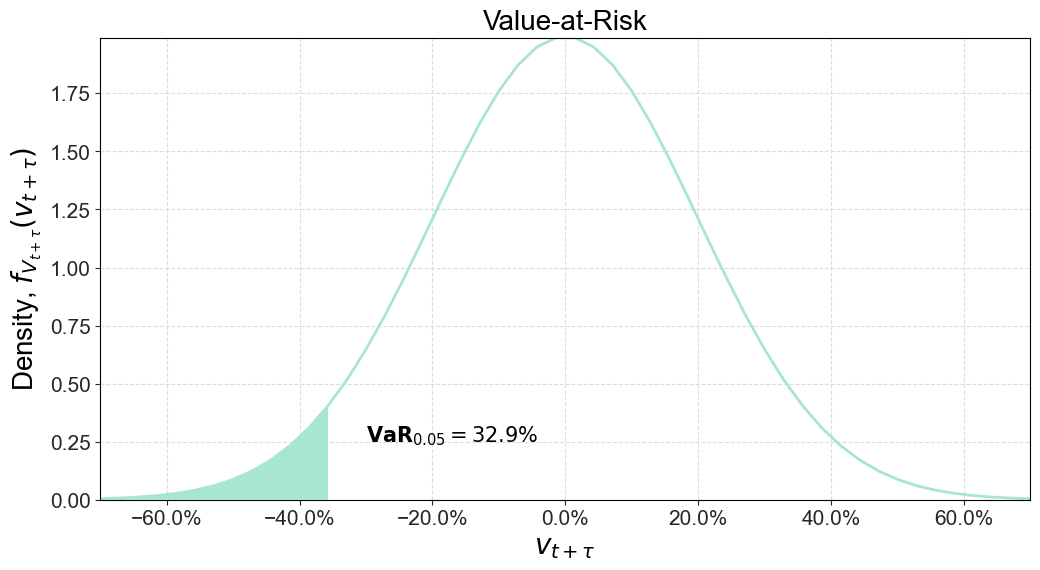

In [2]:
mu = 0.0
sigma = 0.2

# calculate 5% VaR
value_at_risk = stats.norm.ppf(0.05, loc=mu, scale=sigma)

# values for plotting the pdf
v_values = np.linspace(-0.7, 0.7)
pdf_values = stats.norm.pdf(v_values, loc=mu, scale=sigma)

"""
Plotting 
"""

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(v_values, pdf_values)
ax.fill_between(v_values, pdf_values, where=v_values<value_at_risk)
ax.set_title("Value-at-Risk", size=20)
ax.set_xlabel('$v_{t + \\tau}$', size=20)
ax.set_ylabel('Density, $f_{V_{t + \\tau}}(v_{t + \\tau})$', size=20);

# add text
text_to_add =  "$\mathbf{VaR}_{0.05}" + " = {:,.1f}\%$".format(-value_at_risk*100)
ax.text(-0.3, 0.25, text_to_add);

# x-axis a percent
xticks = mtick.PercentFormatter(xmax=1.0, decimals=1)
ax.xaxis.set_major_formatter(xticks)

If we consider a portfolio of assets

$$
\mathbf{P}_{t + \tau} \sim N(\boldsymbol{\mu}, \boldsymbol{\Sigma})
$$

Then the net profits of a portfolio $\mathbf{V}_{t + \tau} = \mathbf{w}^\top \left(\mathbf{P}_{t + \tau} - \mathbf{P}_t \right)$ will be distributed as (note that $\mathbf{P}_t$ is known at time $t$)

$$
\mathbf{V}_{t + \tau} \sim N\left(\mathbf{w}^\top\left(\boldsymbol{\mu} -\mathbf{P}_t \right), \mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w} \right)
$$

Thus, we could easily use a univariate normal distribution to calculate the $\text{VaR}$. But this is not generally the case! E.g. if we assume (which often is a better approximation)

$$
\mathbf{P}_{t + \tau} \sim \log N(\boldsymbol{\mu}, \boldsymbol{\Sigma})
$$

Then, we do not have an easy closed-form expression for the distribution of $\mathbf{V}_{t + \tau}$. Therefore, we often must resort to simulations or approximations to calculate the Value at Risk for a portfolio. 

### Cornish-Fisher approximation 

__Note:__ I do not expect you to know all the details, but simply that you can apply the approximation. 

One often used approximation is the Cornish-Fisher approximation (based on a Cornish-Fisher expansion). [Cornish and Fisher (1937)](https://digital.library.adelaide.edu.au/dspace/bitstream/2440/15229/1/148.pdf)  used an asymptotic expansion to approximate the quantiles of a probability distribution based on its [cumulants](https://en.wikipedia.org/wiki/Cumulant).

We note that the $n$'th cumulant of a random variable $X$ can be found using the cumulant genrating function 

$$
 K(t)=\log \text {E} \left[e^{tX}\right] = \sum _{n=1}^{\infty }\kappa _{n}{\frac {t^{n}}{n!}}=\mu t+\sigma ^{2}{\frac {t^{2}}{2}}+\cdots 
$$

by differentiating $n$ times and evaluating at $t=0$. If we denote the mean by $\mu$ and the central moments by $\mu_k = \text{E}[(X-\mu)^k]$ one can show that the first four cumulants are 

$$
\begin{align}
\kappa_1 &= \mu \\
\kappa_2 &= \mu_2 = \sigma^2 \\
\kappa_3 &= \frac{\mu_3}{\kappa_2^{3/2}} = \frac{\mu_3}{\sigma^3} = \text{Skew}(X) \\
\kappa_4 &= \frac{\mu_4}{\kappa_2^{2}}  - 3= \frac{\mu_4}{\sigma^4} = \text{Kurt}(X)
\end{align}
$$

The Cornish-Fisher approximation using the first four cumulants of a random variable $X$ with mean $\mu$ and variance $\sigma^2$ is given by ([see here](https://en.wikipedia.org/wiki/Cornish%E2%80%93Fisher_expansion))

$$
Q_X(p) = \mu + \sigma \left[z_p +  \text{Skew}(X) \frac{He_2(z_p)}{6} +  \text{Kurt}(X) \frac{He_3(z_p)}{24} - \text{Skew}(X)^2 \frac{2He_3(z_p) + He_1(z_p)}{36}  \right]
$$

where $He_n$ is the n'th order ["probabilist's" Hermite polynomial](https://en.wikipedia.org/wiki/Hermite_polynomials) and $z_p$ is the $p$ percentile of the standard normal distribution. 

__Example: Approximation to log-normal__

Assume that $X \sim \log N(0, 0.2)$. Calculate the $5\%$ percentile of $X$. Define a funtion that calculates the Cornish-Fisher approximation. Use this to calculate the $5\%$ percentile of $X$. 

In [3]:
mu = 0.0
sigma = 0.2

stats.lognorm.ppf(0.05, s = sigma, scale = np.exp(mu))

0.719664084323889

In [4]:
def calculate_cornish_fisher_percentile(alpha, mu, sigma, skew, kurt):

    """
    Calculates the percentile, alpha, based on the Cornish-Fisher approximation 

    Parameters
    ----------
    alpha: float
    mu: float
    sigma: float
    skew: float
    kurt: float

    Returns
    -------
    float
        Percentile

    """

    z = stats.norm.ppf(alpha)
    he2 = np.polynomial.hermite_e.hermeval(z, [0.0, 0.0, 1.0])
    he3 = np.polynomial.hermite_e.hermeval(z, [0.0, 0.0, 0.0, 1.0])
    he13 = np.polynomial.hermite_e.hermeval(z, [0.0, -1.0, 0.0, -2.0])
    
    w = (z +
         he2*skew/6 +
         he3*kurt/24 +
         he13*(skew**2)/36)
    
    return mu + sigma * w

In [5]:
mu_new, var, skew, kurt = stats.lognorm.stats(s = sigma, scale = np.exp(mu),  moments='mvsk')

calculate_cornish_fisher_percentile(0.05, mu_new, np.sqrt(var), skew, kurt)

0.7214712371864381

### Simulation 

Another often used approach is to calculate $\text{VaR}$ using simulations. Let us revist a simple example where we assume that log returns (the market invariants) follow a multivariate normal distribution 

$$
\mathbf{r}_{t+ \tau, \tau} = \log \frac{\mathbf{P}_{t+\tau}}{\mathbf{P}_t} \sim N(\boldsymbol{\mu}, \boldsymbol{\Sigma})
$$

We also remember that we can write 

$$
\mathbf{R}_{t + \tau, \tau} = e^{\mathbf{r}_{t+ \tau, \tau}} - 1
$$

The investor is interested in the $\text{VaR}$ of $\mathbf{V}_{t + \tau} = \mathbf{w}^\top\mathbf{R}_{t + \tau, \tau}$. By simulating enough times, we can "estimate" the  $\text{VaR}$. 

__Example: Calculating VaR using simulations__

Consider a two asset example with stocks (S) and bonds (B) and assume that log returns are bivariate normally distributed. Stocks are defined by $\mu_S = 0.04, \sigma_S = 0.15$ and bonds are defined by $\mu_B = 0.01, \sigma_B = 0.06$. The correlation between stocks and bonds is $\rho _{S,B} = 0.2$.

Calculate the 5\% $\text{VaR}$ of an equally weighted porfolio (of linear returns). 

In [6]:
"""
Define relevant information 
"""

w_eq = np.array([0.5, 0.5])

mu_s = 0.06
mu_b = 0.01
sigma_s = 0.15
sigma_b = 0.075
rho = 0.2

mus = np.array([mu_s, mu_b])
vols = np.array([sigma_s, sigma_b])
corr_mat = np.array([[1.0, rho], [rho, 1.0]])
cov_mat = np.outer(vols, vols) * corr_mat

"""
Simulate 
"""
num_sim = 99999
sim_log_returns = np.random.multivariate_normal(mus, cov_mat, size=num_sim)
sim_lin_returns = np.exp(sim_log_returns) - 1.0
sim_port_returns = sim_lin_returns @ w_eq

# use numpys percentile to calculate the fifth percentile (note the use of 5 and not 0.05)
value_at_risk = np.percentile(sim_port_returns, q=5)

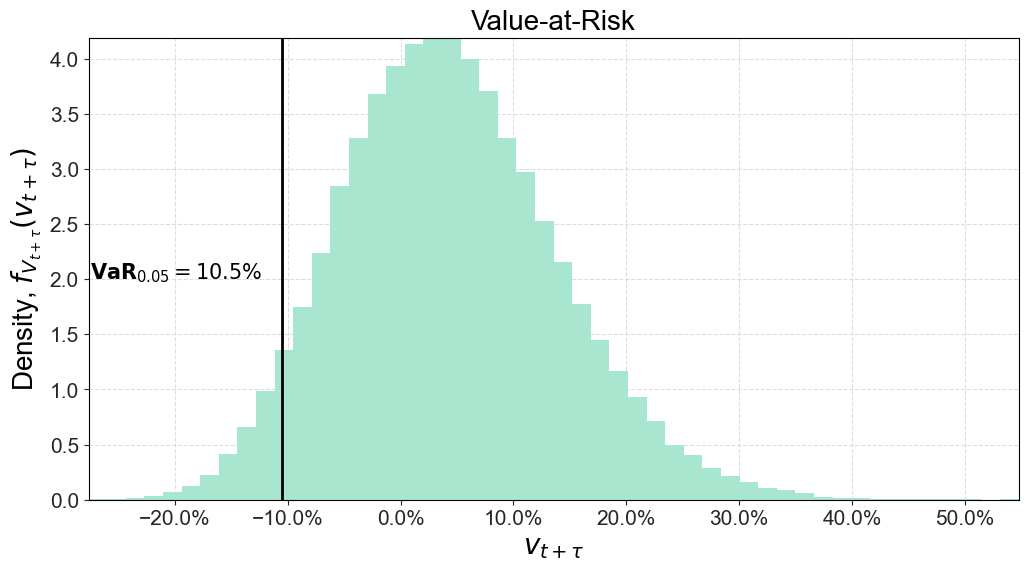

In [7]:
"""
Plotting
"""

fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(sim_port_returns, density=True, bins=50)
ax.axvline(value_at_risk, ymin=0, ymax=4.1, color="black")
ax.set_title("Value-at-Risk", size=20)
ax.set_xlabel('$v_{t + \\tau}$', size=20)
ax.set_ylabel('Density, $f_{V_{t + \\tau}}(v_{t + \\tau})$', size=20);

# add text
text_to_add =  "$\mathbf{VaR}_{0.05}" + " = {:,.1f}\%$".format(-value_at_risk*100)
ax.text(-0.275, 2.0, text_to_add);

# x-axis a percent
xticks = mtick.PercentFormatter(xmax=1.0, decimals=1)
ax.xaxis.set_major_formatter(xticks)

## Conditional Value-at-Risk  (Expected shortfall)

We have previously noted that $\text{VaR}$ is not a coherent risk measure since it does not satisfy the requirement of sub-additivity:

$$
\mathrm{If}\; Z_1, Z_2 \in \mathcal{L} ,\; \mathrm{then}\; \text{VaR}(Z_1 + Z_2) \nleq \text{VaR}(Z_1) + \text{VaR}(Z_2)
$$

This means that $\text{VaR}$ (sometimes) will not promote diversification - this is quit problematic when diversification is key in asset allocation! 

The Conditional Value-at-Risk (or Expected shortfall), $\text{CVaR}$,  is a coherent risk measure that is sub-additive. The $\text{CVaR}$ is defined as the average $\text{VaR}$

$$
\text{CVaR}_{\alpha}(X) = \frac{1}{\alpha} \intop_{0}^{\alpha} \text{VaR}_{s} (X) ds 
$$

If we assume that the linear return of an asset is distributed (1 year horizon) as $\mathbf{V}_{t + 1} = \frac{P_{t+1}}{P_t} - 1   \sim  N(0, 0.2)$, then we can use the quantile function of a normal distribution 

$$
\text{CVaR}_{\alpha} = -\mu + \sigma \frac{\phi\left(\Phi^{-1}(\alpha) \right)}{\alpha}
$$

where $\phi()$ and $\Phi^{-1}$ denote the standard normal pdf and quantile function respectively. 

Below we use `scipy.stats.norm` to calculate the 5\% CVaR and illustrate it. 

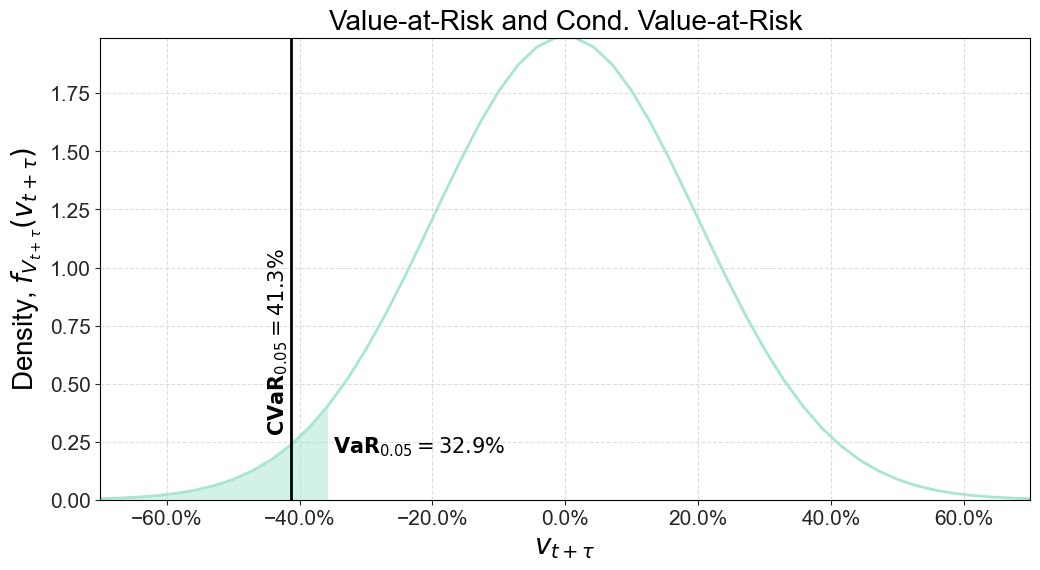

In [8]:
mu = 0.0
sigma = 0.2

# calculate 5% VaR and CVaR
value_at_risk = stats.norm.ppf(0.05, loc=mu, scale=sigma)
cond_value_at_risk = mu -  sigma*stats.norm.pdf(stats.norm.ppf(0.05)) / 0.05

# values for plotting the pdf
v_values = np.linspace(-0.7, 0.7)
pdf_values = stats.norm.pdf(v_values, loc=mu, scale=sigma)

"""
Plotting 
"""

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(v_values, pdf_values)
ax.fill_between(v_values, pdf_values, where=v_values<value_at_risk, alpha=0.5)
ax.axvline(cond_value_at_risk, ymin=0, ymax=4.1, color="black")
ax.set_title("Value-at-Risk and Cond. Value-at-Risk", size=20)
ax.set_xlabel('$v_{t + \\tau}$', size=20)
ax.set_ylabel('Density, $f_{V_{t + \\tau}}(v_{t + \\tau})$', size=20);

# add text
text_to_add =  "$\mathbf{VaR}_{0.05}" + " = {:,.1f}\%$".format(-value_at_risk*100)
text_to_add_2 =  "$\mathbf{CVaR}_{0.05}" + " = {:,.1f}\%$".format(-cond_value_at_risk*100)
ax.text(-0.35, 0.20, text_to_add);
ax.text(-0.45, 0.3, text_to_add_2,rotation=90);

# x-axis a percent
xticks = mtick.PercentFormatter(xmax=1.0, decimals=1)
ax.xaxis.set_major_formatter(xticks)

# References

## Articles
[Artzner et al (1999), "Coherent Measures of Risks"](https://onlinelibrary.wiley.com/doi/abs/10.1111/1467-9965.00068)

[Bruder and Roncalli (2012), "Managing Risk Exposures using
the Risk Budgeting Approach"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2009778)

[Cornish and Fisher (1937)](https://digital.library.adelaide.edu.au/dspace/bitstream/2440/15229/1/148.pdf)


## Books

[Attilio Meucci, "Risk and Asset Allocation"](https://www.amazon.com/Risk-Asset-Allocation-Springer-Finance/dp/3642009646)